<a href="https://colab.research.google.com/github/Kanekohe/master-thesis/blob/main/Hamilton_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

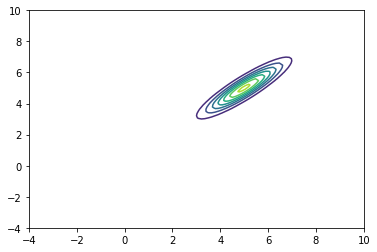

In [ ]:
import numpy as np
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt

mu = np.array([5, 5])
sigma = np.array([[1, 0.9], [0.9, 1]])

def pgauss_0(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mu, cov=sigma)

xvar = np.linspace(-4.0, 10.0, 100)
yvar = np.linspace(-4.0, 10.0, 100)
zvar = np.array([[pgauss_0(u,v) for u in xvar] for v in yvar])
plt.contour(xvar,yvar,zvar)
plt.show()

## 準備
確率分布の対数やその微分，ハミルトニアンの定義．

In [ ]:
def log_distribution(x,y,mu,sigma):
    return np.log(st.multivariate_normal.pdf([x, y], mean=mu, cov=sigma))
def dx_log_distribution(x,y,mu,sigma):#x方向の微分
    det = sigma[0,0]*sigma[1,1]-sigma[0,1]*sigma[1,0]
    return -(x-mu[0])*sigma[1,1]/det-0.5*(y-mu[1])*(-sigma[1,0]-sigma[0,1])/det
def dy_log_distribution(x,y,mu,sigma):#y方向の微分
    det = sigma[0,0]*sigma[1,1]-sigma[0,1]*sigma[1,0]
    return -(y-mu[1])*sigma[0,0]/det-0.5*(x-mu[0])*(-sigma[1,0]-sigma[0,1])/det

def kinetic(px,py,tau):
    return (px**2+py**2)*0.5/tau**2
def d_kinetic(p,tau):
    return p/tau**2

def Hamiltonian(x,y,px,py,tau):#Hamiltonianの決定
    global mu, sigma
    return kinetic(px,py,tau)+(-1.*log_distribution(x,y,mu,sigma))

## Leap-frog step
xとyの運動量が与えられると，ハミルトン方程式の差分ステップは以下のようになる．

In [ ]:
# Leap-frog step
def step_leapfrog(epsilon,x,y,px,py,tau):
    global mu, sigma
    x += -0.5*epsilon*(-1.*d_kinetic(px,tau))
    y += -0.5*epsilon*(-1.*d_kinetic(py,tau))
    px += epsilon*dx_log_distribution(x,y,mu,sigma)
    py += epsilon*dy_log_distribution(x,y,mu,sigma)
    x += -0.5*epsilon*(-1.*d_kinetic(px,tau))
    y += -0.5*epsilon*(-1.*d_kinetic(py,tau))
    return x,y,px,py

## Hamiltonian MCの１ステップ

In [ ]:
# １ HMC step
def step_HMC(x,y,tau,epsilon,T):
    global mu, sigma
    px, py = np.random.normal(0,tau,size=2)
    px_new = px
    py_new = py
    x_new = x
    y_new = y
    n_flg = 0
    for t in range(T):
        x_new, y_new, px_new, py_new = step_leapfrog(epsilon, x_new, y_new, px_new, py_new, tau)
        
    prob = np.exp(Hamiltonian(x, y, px, py, tau) - Hamiltonian(x_new, y_new, px_new, py_new, tau))
    u = np.random.uniform()
#    print(prob,u)
    if u < prob:
        x = x_new
        y = y_new
        n_flg = 1
        
    return x, y, n_flg

# sampling by HMC
def proceed_HMC(tau, epsilon, T, ite, x_0, y_0):
    # Initialize
    x = [x_0]
    y = [y_0]
    n_accepted = 0
    for i in range(ite):
        x_new, y_new, n_flg = step_HMC(x[i], y[i], tau, epsilon, T)
        x.append(x_new)
        y.append(y_new)
        n_accepted += n_flg
    
    print("Acceptance rate: ", n_accepted/ite)
    return x,y 

Acceptance rate:  1.0


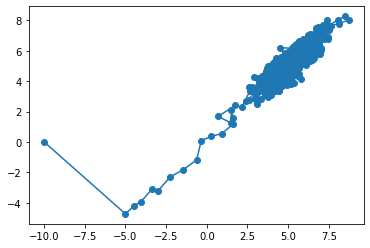

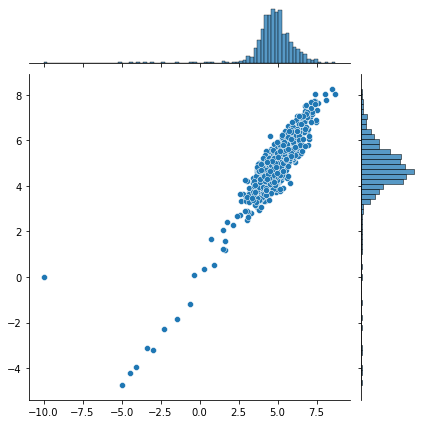

In [ ]:
x_0 = -10.0
y_0 = .0
X, Y = proceed_HMC(tau=2.0, epsilon=0.05, T=20, ite=1000, x_0=x_0, y_0=y_0)

plt.plot(X, Y, marker="o")
sns.jointplot(x=X, y=Y)         
plt.show()